# TRS Dataset Exploration and KNN Classifier

This notebook loads the **TRS** dataset, performs an exploratory data analysis (EDA), and trains a K-Nearest Neighbors (KNN) classifier as a teaching example.

## 1. Setup

Import the required libraries for data handling, visualization, and modeling.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")

## 2. Load TRS Dataset

We load the training and evaluation datasets from local CSV files as pandas DataFrames for easier analysis.

### 2.2 Load Training and Evaluation Datasets

Load the training dataset for model development and the evaluation dataset for final testing.

In [2]:
# Load training dataset
df_train = pd.read_csv('./trs_train.csv')
X_train_full = df_train.iloc[:,1:].drop('TRS', axis=1)
y_train_full = df_train['TRS']

# Load evaluation dataset
df_eval = pd.read_csv('./trs_eval.csv')
X_eval = df_eval.iloc[:,1:]

print(f"Training set: {X_train_full.shape}")
print(f"Training class distribution:")
print(y_train_full.value_counts())
print(f"\nEvaluation set: {X_eval.shape}")


Training set: (9000, 26)
Training class distribution:
TRS
0    6162
1    2838
Name: count, dtype: int64

Evaluation set: (1000, 26)


## 3. Exploratory Data Analysis (EDA)

Take a first look at the training dataset structure and basic statistics to understand the information it contains.

In [3]:
# Preview the first rows
X_train_full.head()

,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,Triglycerides,...,HLA_A_31_01,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum
0,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,230.6,...,1,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133
1,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,58.9,...,0,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502
2,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,NaN,...,0,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842
3,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,152.5,...,0,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249
4,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,221.0,...,0,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533


In [4]:
# Dataset info summary (captured via buffer to display as text in notebook)
from io import StringIO
buffer = StringIO()
X_train_full.info(buf=buffer)
print(buffer.getvalue())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           9000 non-null   float64
 1   Sex                           9000 non-null   int64  
 2   Ethnicity                     9000 non-null   object 
 3   Duration_untreated_psychosis  8872 non-null   float64
 4   Family_history                9000 non-null   int64  
 5   Initial_response              9000 non-null   float64
 6   Lymphocyte_count              7009 non-null   float64
 7   Neutrophil_count              7015 non-null   float64
 8   BMI                           9000 non-null   float64
 9   Triglycerides                 6547 non-null   float64
 10  Glucose                       6381 non-null   float64
 11  Alkaline_phosphatase          6062 non-null   float64
 12  Prior_antipsychotics          9000 non-null   int64  
 13  CYP

In [5]:
# Missing values per column
missing_values = X_train_full.isna().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Alkaline_phosphatase            2938
Glucose                         2619
Triglycerides                   2453
Lymphocyte_count                1991
Neutrophil_count                1985
Duration_untreated_psychosis     128
IL_17A                             1
Polygenic_risk_score               1
dtype: int64

In [6]:
# Descriptive statistics for numerical columns
X_train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,9000.0,26.039444,10.011767,13.00000,19.00000,25.00000,31.00000,64.000
Sex,9000.0,0.576000,0.494218,0.00000,0.00000,1.00000,1.00000,1.000
Duration_untreated_psychosis,8872.0,19.220548,19.545745,0.30000,6.40000,12.50000,24.30000,125.000
Family_history,9000.0,0.118778,0.323545,0.00000,0.00000,0.00000,0.00000,1.000
Initial_response,9000.0,41.840367,30.160230,0.00000,10.10000,38.20000,72.30000,100.000
Lymphocyte_count,7009.0,1.795761,0.601099,0.50000,1.38000,1.80000,2.20000,4.020
Neutrophil_count,7015.0,5.014574,1.471581,1.50000,4.00500,5.02000,6.01000,9.960
BMI,9000.0,28.107556,5.433100,15.00000,24.40000,28.00000,31.70000,49.600
Triglycerides,6547.0,152.012800,61.099018,40.00000,108.05000,151.10000,194.60000,394.600
Glucose,6381.0,95.859881,18.310027,65.00000,82.20000,95.50000,108.30000,159.600


TRS
0    6162
1    2838
Name: count, dtype: int64


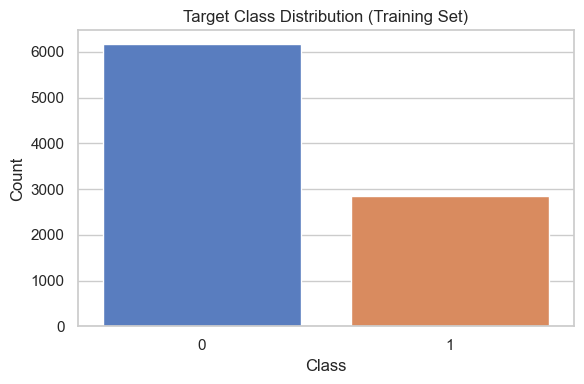

In [7]:
# Target distribution
class_counts = y_train_full.value_counts().sort_values(ascending=False)
print(class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="muted")
plt.title("Target Class Distribution (Training Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

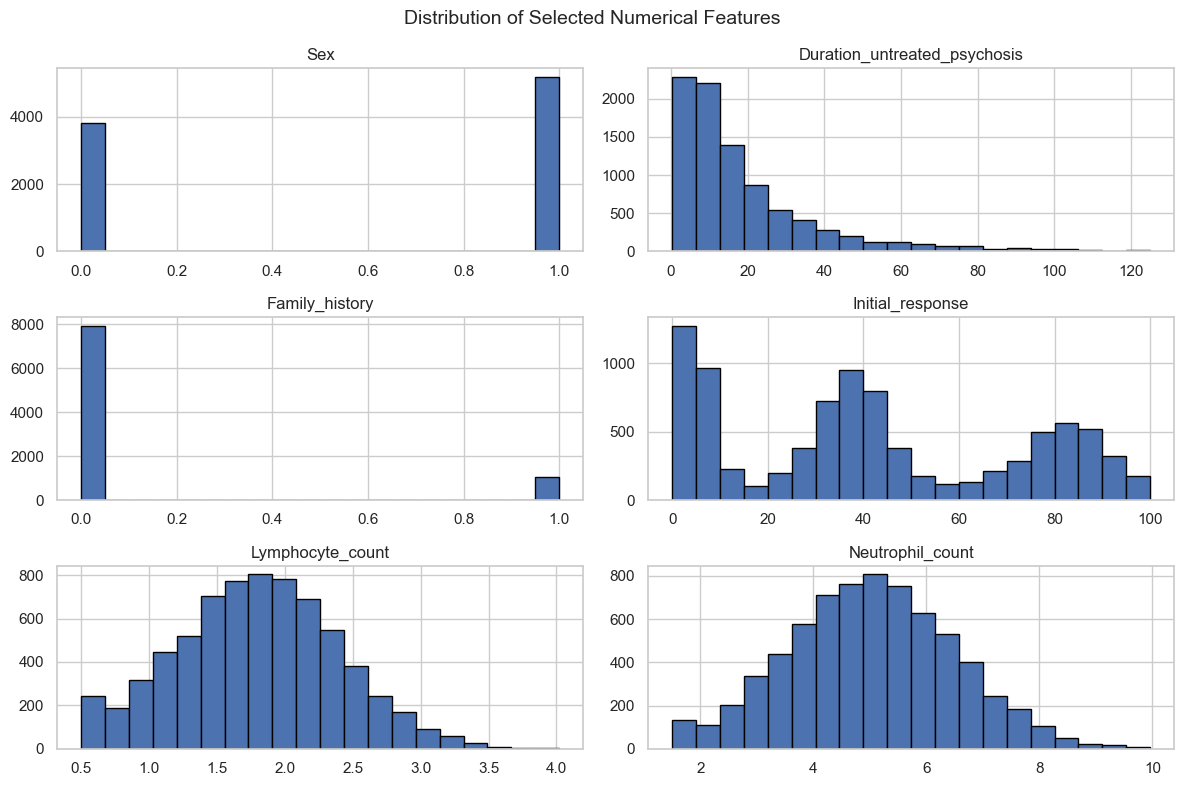

In [8]:
# Histograms for a subset of numerical features
numeric_features = X_train_full.select_dtypes(include=[np.number]).columns
sample_features = numeric_features[1:7]

X_train_full[sample_features].hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Distribution of Selected Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

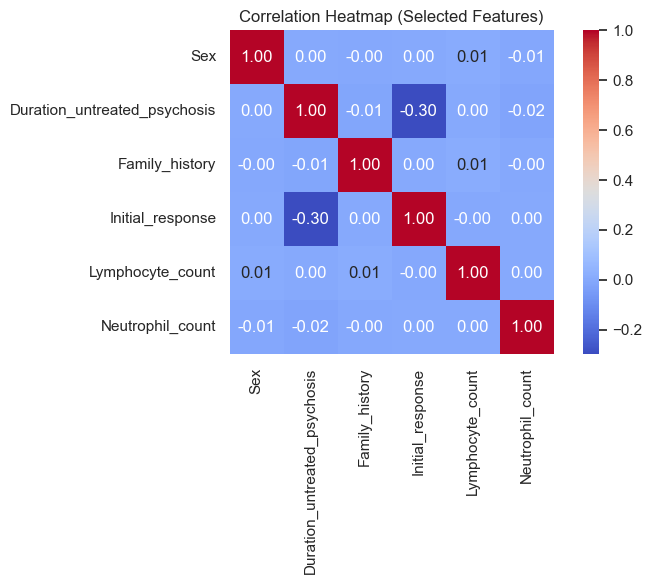

In [9]:
# Correlation heatmap of selected features
corr_matrix = X_train_full[sample_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.show()

## 4. Prepare Data for Model Development

Split the training dataset into train and validation sets for model tuning and validation.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Evaluation features: {X_eval.shape}")

Training features: (7200, 26)
Validation features: (1800, 26)
Evaluation features: (1000, 26)


## 5. Build and Tune KNN Classification Pipeline

We build a preprocessing pipeline that imputes missing values, scales features, and runs a KNN classifier. Hyperparameters are tuned via cross-validation on the training set.

In [11]:
numeric_columns = X_train_full.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_columns = X_train_full.columns.difference(numeric_columns).tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_columns),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), non_numeric_columns)
    ],
    remainder="drop"
)

knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring="accuracy",
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

print(f"Best CV accuracy: {knn_grid.best_score_:.3f}")
print(f"Best params: {knn_grid.best_params_}")

Best CV accuracy: 0.666
Best params: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}


## 6. Validate the Model

Evaluate the tuned model on the validation set to check performance before final evaluation.

Validation Accuracy: 0.668

Classification Report (Validation Set):

              precision    recall  f1-score   support

           0       0.70      0.90      0.79      1232
           1       0.43      0.17      0.24       568

    accuracy                           0.67      1800
   macro avg       0.57      0.53      0.52      1800
weighted avg       0.62      0.67      0.62      1800



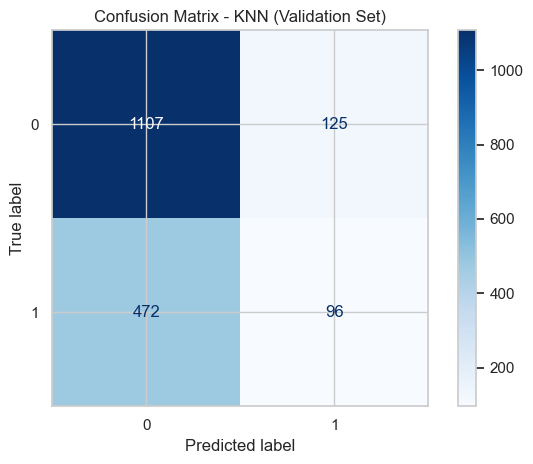

In [12]:
best_knn = knn_grid.best_estimator_
y_val_pred = best_knn.predict(X_val)

print("Validation Accuracy: {:.3f}".format((y_val_pred == y_val).mean()))
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_val, y_val_pred))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap="Blues")
plt.title("Confusion Matrix - KNN (Validation Set)")
plt.tight_layout()
plt.show()

## 7. Final Evaluation on Test Set and Kaggle Submission File Creation

Evaluate the model on the held-out evaluation dataset (trs_eval.csv) to assess its generalization performance in the Kaggle competition. Create a submission file with the predicted TRS values for the evaluation set. 


In [13]:
# Load test data from CSV file
test_df = pd.read_csv('./trs_eval.csv')

# Load test data from Kaggle input
# test_df = pd.read_csv('/kaggle/input/iaa-trs-detection/trs_eval.csv')

print(f"\nTest data shape: {test_df.shape}")

# Make predictions
y_pred = best_knn.predict(test_df)

print(f"\nPredictions distribution:\n{pd.Series(y_pred).value_counts()}")

patient_ids = range(1, len(test_df) + 1)

# Create submission file
submission = pd.DataFrame({
    'patient_id': patient_ids,
    'TRS': y_pred
})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created: submission.csv")
print(f"Submission shape: {submission.shape}")
print("\nFirst few rows:")
print(submission.head(10))


Test data shape: (1000, 27)

Predictions distribution:
0    895
1    105
Name: count, dtype: int64

Submission file created: submission.csv
Submission shape: (1000, 2)

First few rows:
   patient_id  TRS
0           1    0
1           2    0
2           3    0
3           4    0
4           5    1
5           6    0
6           7    1
7           8    0
8           9    0
9          10    0


## 8. Conclusions and Next Steps

- The preprocessing + KNN pipeline provides a baseline classifier for the TRS dataset.
- The model was trained on trs_train.csv and validated using cross-validation and a held-out validation set.
- Final submission file was generated on trs_eval.csv.
- Next steps:
  - Investigate other models (e.g., Logistic Regression, Random Forest, XGBoost) and compare results.
  - Consider dimensionality reduction (PCA, UMAP) to visualize high-dimensional patterns.
  - Analyze misclassified samples to identify patterns and potential improvements.